## Set up paths and imports

In [1]:
import os

import torch
from torchvision import transforms
import matplotlib.pyplot as plt

if not os.path.exists("./notebooks"):
    %cd ..

import src.model
from PIL import Image
from src.data_processing import load_mean_std
from src.config import DATASET_DIR
from src.dataset_analysis import plot_spectrogram
from src.training import process_predictions_and_features
from src.dataset import prepare_dataset_loaders


/Users/boryskurdek/Studia/ml/iml


/Users/boryskurdek/Studia/ml/iml/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load Model and Dataset

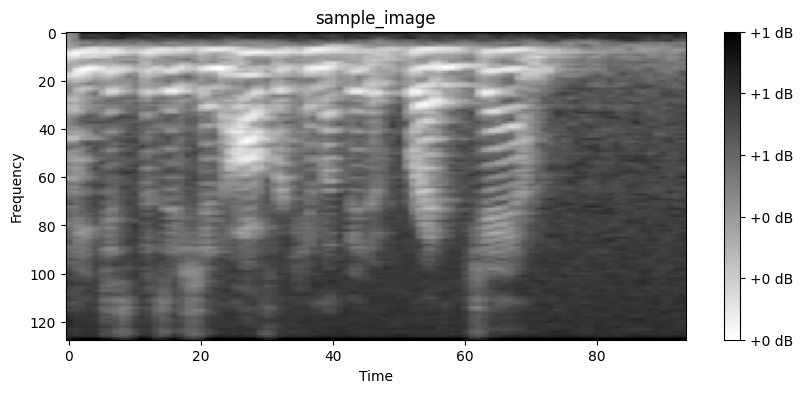

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

name = "OriginalSizeCNN-HE-RELU"
model = src.model.OriginalSizeCNN()
model_path = f"./models/{name}.pth"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.device = device
model = model.to(device)

mean, std = load_mean_std(f"{DATASET_DIR}/scaling_params.json")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

image_path = "datasets/test/f1_script4_ipadflat_office1_16_clip.png"
#image_path ="datasets/val/f1_script2_ipad_balcony1_1_clip.png"
sample_image = Image.open(image_path).convert("L")
sample_image = transform(sample_image)
plot_spectrogram(plt.imread(image_path), "sample_image")


#sample_image = test_loader.dataset[0][0]


## Get feture map for first Convolutional Layer

In [3]:
c1_layer = src.model.ModelWithLayerOutput(model,"conv1")
c1_layer.device = device
c1_feature_map = c1_layer(sample_image).detach().numpy()

## Visualize feature map

In [4]:
def plot_feature_map(feature_map, max_grid):
    
    fig, ax = plt.subplots(max_grid, max_grid, figsize=(7,7))
    channel_idx = 0
    
    for i in range(max_grid):
        for j in range(max_grid):
            ax[i][j].imshow(feature_map[channel_idx,:,:])
            ax[i][j].axis('off')
            
            channel_idx += 1
            
    fig.suptitle(f'Feature Map - Displaying {max_grid**2} of {feature_map.shape[0]} Channels')
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

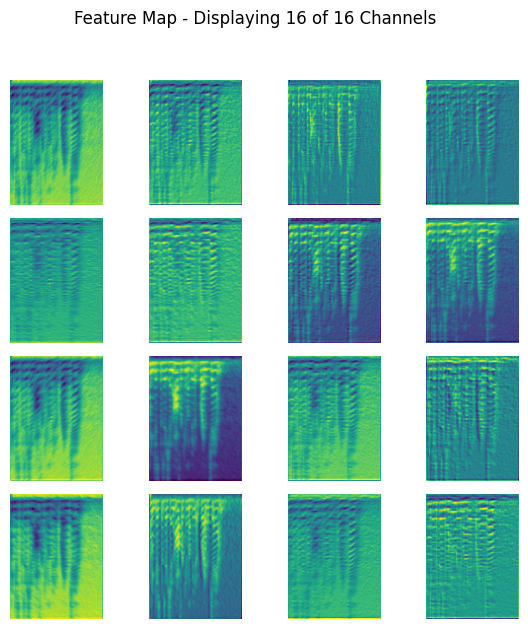

In [5]:
plot_feature_map(c1_feature_map, 4)

## Feature maps from seconds layer

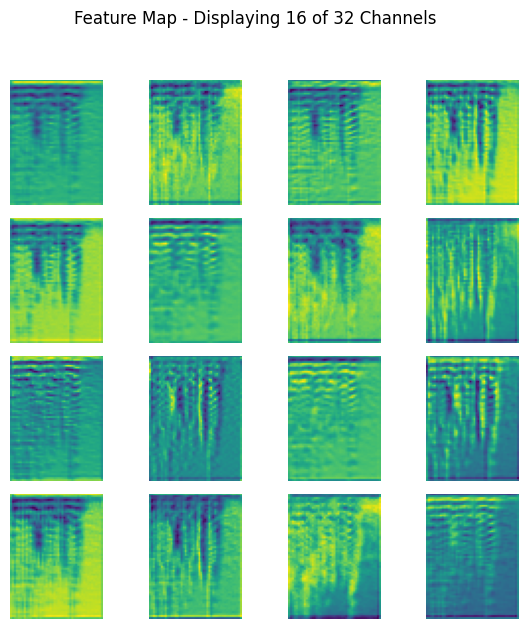

In [6]:
c2_layer = src.model.ModelWithLayerOutput(model,"conv2")
c2_layer.device = device
c2_feature_map = c2_layer(sample_image).detach().numpy()
plot_feature_map(c2_feature_map, 4)

## Compare feature maps from third layer

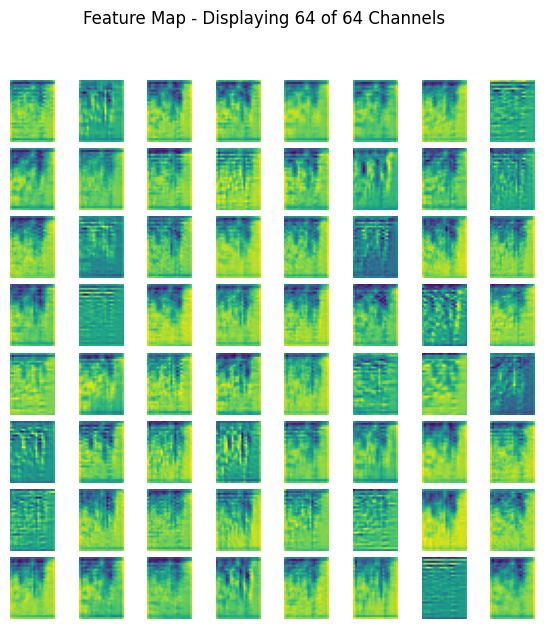

In [7]:
c3_layer = src.model.ModelWithLayerOutput(model,"conv3")
c3_layer.device = device
c3_feature_map = c3_layer(sample_image).detach().numpy()
plot_feature_map(c3_feature_map, 8)

## Similarity Search

Now that we understand how to extract semantically meaningful features with a pretrained CNN, we can explore how to use those features for the purpose of search in a scalable manner. Facebook AI Similarity Search (FAISS) is a highly optimized library that allows us to do just that - compare a query record (e.g. feature vector) against a stored database of other feature vectors to retrive those that are most similar. There are various metrics used for calculating "similarity" of two vectors, but at its simplest, similar vectors are defined as those that are nearby in Euclidean space. For more info on FAISS, check out this article.

To demonstrate FAISS in action, we'll first get feature maps from both convolution layer outputs above (block1_conv1, block5_conv3) for every image in the ICONIC200 dataset. We'll create and add all vectors from each feature map into their own FAISS index, and use those indicies for searching images against all others. Finally, we'll plot comparative similarity search results using the two feature maps for a given input image.

In [31]:
batch_size = 4 
_, _, test_loader = prepare_dataset_loaders(transform, batch_size)
c3_layer.device = "cpu"
c3_layer = c3_layer.to("cpu")
preds, feature_maps = process_predictions_and_features(c1_layer, test_loader)
preds_c3, feature_maps_c3 = process_predictions_and_features(c3_layer, test_loader)





In [34]:
# Create FAISS index for each set of features, held in dict
import faiss
import numpy as np
feature_maps = np.vstack(feature_maps)
feature_maps_c3 = np.vstack(feature_maps_c3)

indicies = {}
features = {'c1_layer': feature_maps,
            'c3_layer': feature_maps_c3}

for name, feature_map in features.items():
    feature_dim = feature_map.shape[1]
    index = faiss.IndexFlatL2(feature_dim)
    index.add(feature_map)
    
    indicies[name] = index

In [53]:
# Define function that uses index to retrieve top N similar vectors (distances and indicies)
def load_images(directory, transform):
    images = []
    #image_files = sorted(os.listdir(directory))  # Sort to ensure consistent indexing
    for filename in image_files:
        filepath = os.path.join(directory, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = Image.open(filepath).convert("L")
            image = transform(image)
            images.append(image)
    return images, image_files
    
def get_similar(index, query_vec, k):
    distances, indices = index.search(query_vec, k)
    return distances, indices

# Define function to visually compare top similar results for a given query image against feature maps
def plot_n_similar(faiss_indicies, image_holder, image_files, feature_maps, query_idx, k):
    
    # Get similar vectors for each conv layer
    sim_indicies = {}
    for layer in faiss_indicies.keys():
        dist, indic = get_similar(faiss_indicies[layer],
                                  feature_maps[layer][query_idx:query_idx+1], k)
        
        sim_indicies[layer] = indic
    
    # Plot query image
    plt.title(f'Query Image - {image_files[query_idx]}' )
    query_img = image_holder[query_idx]
    plt.imshow(query_img.squeeze(0), cmap="gray")

    
    # Plot k most similar images for each layers feature map
    fig, ax = plt.subplots(2, k)
    
    i = 0
    for layer, indic in sim_indicies.items():
        indic = indic.ravel()
        for j in range(len(indic)):
            ax[i][j].axis('off')
            ax[i][j].imshow(image_holder[indic[j]].squeeze(0),cmap="gray")
            ax[i][j].set_title(f'Rank {j+1} - {layer} - {image_files[indic[j]]}', fontsize=5)
        i += 1
        
    plt.tight_layout() 
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(f'Top {k} Most Similar Images by Feature Map')
    plt.show()

3858
Loaded 3858 images: ['f10_script4_ipad_balcony1_0_clip.png', 'f10_script4_ipad_balcony1_10_clip.png', 'f10_script4_ipad_balcony1_11_clip.png', 'f10_script4_ipad_balcony1_12_clip.png', 'f10_script4_ipad_balcony1_13_clip.png']...


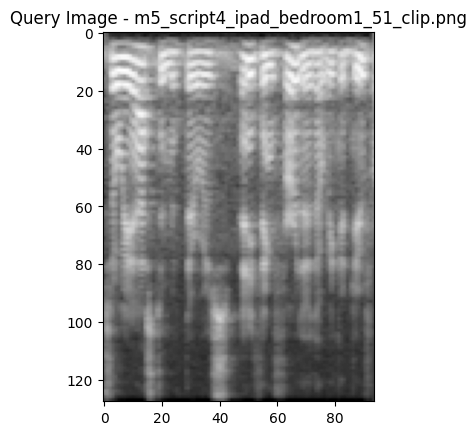

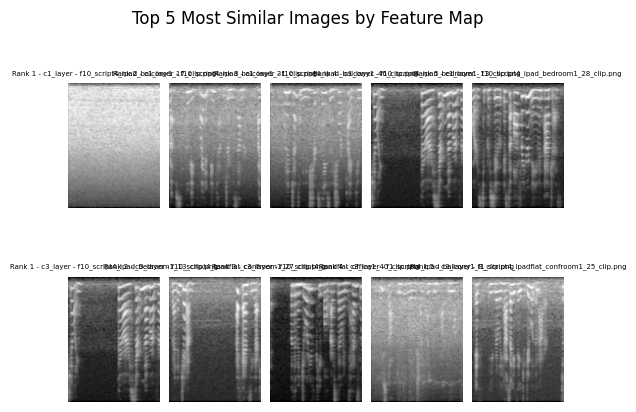

In [54]:
images, image_files = load_images("datasets/test", transform)
print(len(images))
print(f"Loaded {len(images)} images: {image_files[:5]}...")  # Print the first few filenames


plot_n_similar(faiss_indicies=indicies,
               image_holder=images,
               image_files=image_files,
               feature_maps=features,
               query_idx=3000,
               k=5)